In [1]:
from forge import *
from puzzle.puzzlepedia import prod_config

prod_config.init()

In [4]:
import cv2
import glob
import itertools
import numpy as np
import math
import matplotlib.pyplot as plt
from IPython.display import display
from PIL import Image
from os import path
from sklearn.neighbors import NearestNeighbors
from typing import Iterable, Tuple

from data import data
from util import perf
from util.geometry import np2d
from data.image import grid, coloring, component, component_database, utils

import importlib
#importlib.reload(grid)
importlib.reload(np2d)
importlib.reload(perf)

dist_technique = perf.Perf('dist_technique', ['min_area', 'overlap', 'segment_distance', 'segment_distance2', 'segment_distance3', 'intersection_distance'])
segment_intersection = perf.Perf('segment_intersection', ['long', 'linalg'])

_FILE_PATTERN = '*.png'
_WHITE = [255, 255, 255]
_THRESHOLD = 5
_SIZES = []
_FOCUS = {
}
pos = 16
for backwards in range(-1, -11, -1):
  for _ in range(0, 8):
    _SIZES.append(pos)
    pos += 1
  _SIZES.append(16 + backwards)

  
def image_path(name: str, subdir: str = 'original') -> str:
  return path.join(data.project_path('data/grid'), subdir, name)


def get_image(name, subdir: str = 'original'):
  # download the image, convert it to a NumPy array, and then read
  # it into OpenCV format
  return cv2.imread(image_path(name, subdir=subdir), flags=cv2.IMREAD_UNCHANGED)


def get_grid(name, subdir: str = 'original'):
  return grid.Grid(get_image(name, subdir=subdir))


def show(img):
  display(Image.fromarray(img))


def show_components(g):
  db = component_database.ComponentDatabase()

  shown = set()
  for c in g.components:
    identified = db.identify(c)
    symbol = identified.labels.get('symbol')
    if symbol is None:
      pass
    elif symbol in shown:
      continue
    shown.add(symbol)
    print(symbol)
    show(c.image)


def images(subdir: str = 'original') -> Iterable[np.ndarray]:
  for filename in sorted(glob.glob(image_path(_FILE_PATTERN, subdir))):
    yield (
      path.basename(filename),
      cv2.imread(filename, flags=cv2.IMREAD_UNCHANGED))


def grids(subdir: str = 'original') -> Iterable[Tuple[str, grid.Grid]]:
  for name, image in images(subdir):
    if _FOCUS and name not in _FOCUS:
      continue
    yield name, grid.Grid(image)


_PADDING = 8


def study(*segments, padding=_PADDING):
  """Studies line segments."""
  segments = [np.array(s) for s in segments]
  min_x = min(s[:, 0].min() for s in segments)
  min_y = min(s[:, 1].min() for s in segments)
  move_to_zero = np.array([min_x, min_y])
  for s in segments:
    print(repr(s))
    s -= move_to_zero - padding
  max_x = int(max(s[:, 0].max() for s in segments) + padding)
  max_y = int(max(s[:, 1].max() for s in segments) + padding)
  image = np.zeros((max_y + 1, max_x + 1, 3), dtype=np.uint8)
  colors = coloring.colors(len(segments))
  for s, color in zip(segments, colors):
    cv2.line(image, tuple(map(int, s[0])), tuple(map(int, s[1])), color.tolist(), 1)
  image = cv2.resize(image, None, fx=2, fy=2)
  show(image)
  return image


class Contour(object):
  def __init__(self, name, original, approx):
    self.name = name
    self.original = original
    self.approx = approx
    #self.convex = cv2.isContourConvex(approx)
    self.moments = cv2.moments(c)
    self.area = self.moments['m00']
    if self.area:
      cX = int((self.moments["m10"] / self.moments["m00"]))
      cY = int((self.moments["m01"] / self.moments["m00"]))
    else:
      cX = 0
      cY = 0
    self.cX = cX
    self.cY = cY
    self.center = np.array((cX, cY))

  def draw_on(self, image, color=(0, 255, 0), bold=False):
    cv2.drawContours(image, [self.approx], -1, color, 1)
    if bold:
      font_weight = 2
    else:
      font_weight = 1
    cv2.putText(
      image, self.name, (self.cX - 9, self.cY + 5), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), font_weight)


def segment_interesting(c1, c2, s):
  return np2d.segments_intersect((c1.center, c2.center), s)


def segment_distance(s1, s2):  # MIGRATE.
  # Test each point in s1 compared to s2 and vice-versa.
  # Return the min of the two scores.
  s1p1, s1p2 = s1
  s2p1, s2p2 = s2
  s1_to_s2 = (np2d.point_to_segment_distance(s1p1, s2) +
              np2d.point_to_segment_distance(s1p2, s2))
  s2_to_s1 = (np2d.point_to_segment_distance(s2p1, s1) +
              np2d.point_to_segment_distance(s2p2, s1))
  return min(s1_to_s2, s2_to_s1) / 2 # Average distance.


def segment_distance2(s1, s2):  # MIGRATE.
  # Test each point in s1 compared to s2 and vice-versa.
  # Return the min of the two scores.
  s1p1, s1p2 = s1
  s2p1, s2p2 = s2
  # Attempt to pair points to form new segments.
  s1 = (s1p1, s2p1)
  s2 = (s1p2, s2p2)
  d1 = (np2d.point_to_point_distance(*s1) +
        np2d.point_to_point_distance(*s2))
  # Flip points.
  s1 = (s1p1, s2p2)
  s2 = (s1p2, s2p1)
  d2 = (np2d.point_to_point_distance(*s1) +
        np2d.point_to_point_distance(*s2))
  return min(float(d1), float(d2)) / 2  # Average distance.


def segment_distance3(s1, s2):  # MIGRATE.
  # Test each point in s1 compared to s2 and vice-versa.
  # Return the min of the two scores.
  # Attempt to pair points to form new segments.
  s1 = np.array(s1)
  s2 = np.array(s2)
  d_s1s2 = s1 - s2
  d1 = sum(np.hypot(d_s1s2[:,0], d_s1s2[:,1]))
  # Flip points.
  d_s1s2 = s1 - s2[::-1]
  d2 = sum(np.hypot(d_s1s2[:,0], d_s1s2[:,1]))
  return min(d1, d2) / 2  # Average distance.


def slope(s):
  a, b = s
  dx, dy = b - a
  if dx == 0:
    return np.pi / 2
  return np.arctan(dy / dx)


_SIMILAR_ANGLES = math.pi / 10
def overlap(s1, s2, threshold=_SIMILAR_ANGLES):
  slope1 = slope(s1)
  slope2 = slope(s2)
  if abs(slope1 - slope2) >= threshold:
    return 0
  # Undo slope1's rotation on s1 and s2.
  c = np.cos(slope1)
  s = np.sin(slope1)
  rotational_transformation = np.array(((c, s), (-s, c)))
  s1p1 = np.dot(rotational_transformation, s1[0])
  s1p2 = np.dot(rotational_transformation, s1[1])
  s2p1 = np.dot(rotational_transformation, s2[0])
  s2p2 = np.dot(rotational_transformation, s2[1])
  left1 = s1p1[0]
  right1 = s1p2[0]
  if left1 > right1:
    left1, right1 = right1, left1
  left2 = s2p1[0]
  right2 = s2p2[0]
  if left2 > right2:
    left2, right2 = right2, left2
  if left1 > left2:
    left1, left2 = left2, left1
    right1, right2 = right2, right1
  min_width = min(right1 - left1, right2 - left2)
  max_y = max(abs(s2p1[1]), abs(s2p2[1]))
  if abs(max_y - abs(s1p1[1])) > min_width:
    # s2 is too far away from s1.
    return 0
  # Return overlap as % of smaller segment.
  return (right1 - left2) / min_width


def overlap(s1, s2, threshold=_SIMILAR_ANGLES):
  slope1 = slope(s1)
  slope2 = slope(s2)
  if abs(slope1 - slope2) >= threshold:
    return 0
  # Undo slope1's rotation on s1 and s2.
  c = np.cos(slope1)
  s = np.sin(slope1)
  rotational_transformation = np.array(((c, s), (-s, c)))
  s1p1 = np.dot(rotational_transformation, s1[0])
  s1p2 = np.dot(rotational_transformation, s1[1])
  s2p1 = np.dot(rotational_transformation, s2[0])
  s2p2 = np.dot(rotational_transformation, s2[1])
  left1 = s1p1[0]
  right1 = s1p2[0]
  if left1 > right1:
    left1, right1 = right1, left1
  left2 = s2p1[0]
  right2 = s2p2[0]
  if left2 > right2:
    left2, right2 = right2, left2
  if left1 > left2:
    left1, left2 = left2, left1
    right1, right2 = right2, right1
  min_width = min(right1 - left1, right2 - left2)
  max_y = max(abs(s2p1[1]), abs(s2p2[1]))
  if abs(max_y - abs(s1p1[1])) > min_width:
    # s2 is too far away from s1.
    return 0
  # Return overlap as % of smaller segment.
  return (right1 - left2) / min_width


def intersection_distance(center_line, s1, s2):
  s1x, s1y = np_linalg(center_line, s1)
  s2x, s2y = np_linalg(center_line, s2)
  return math.hypot(s2x - s1x, s2y - s1y)
  #return np2d.point_to_point_distance(np.array((s1x, s1y)), np.array((s2x, s2y)))


def min_area(s1, s2):
  (cx, cy), (w, h), rot = cv2.minAreaRect(np.vstack([s1, s2]))
  return min(w, h)


def wall_segments(c1, c2, dist_threshold):
  result = []
  center_line = (c1.center, c2.center)
  for s1 in np2d.iter_segments(c1.approx):
    if not segment_interesting(c1, c2, s1):
      continue
    for s2 in np2d.iter_segments(c2.approx):
      if not segment_interesting(c1, c2, s2):
        continue
      with dist_technique.benchmark('min_area'):
        dist0 = min_area(s1, s2)
      min_area_ok = dist0 < dist_threshold
      with dist_technique.benchmark('overlap'):
        p_overlap = overlap(s1, s2)
      overlap_ok = p_overlap > .5
      with dist_technique.benchmark('segment_distance'):
        dist1 = segment_distance(s1, s2)
      segment_distance_ok = dist1 < dist_threshold
      with dist_technique.benchmark('segment_distance2'):
        dist2 = segment_distance2(s1, s2)
      segment_distance2_ok = dist2 < dist_threshold
      with dist_technique.benchmark('segment_distance3'):
        dist2b = segment_distance3(s1, s2)
      if dist2b != dist2:
        raise Exception('dist disagree: %s %s' % (dist2, dist2b))
        #segment_distance2_ok = dist2 < dist_threshold
      #with dist_technique.benchmark('intersection_distance'):
      dist3 = intersection_distance(center_line, s1, s2)
      intersection_distance_ok = dist3 < dist_threshold
      if False: #not (segment_distance2_ok == overlap_ok):
        print('thresholds disagree!')
        print('min_area_ok: %s %.2f\noverlap_ok: %s %.2f\nsegment_distance_ok: %s (%.2f)\nsegment_distance2_ok: %s (%.2f)\nintersection_distance_ok: %s (%.2f)' % (
          str(min_area_ok)[0], dist0,
          str(overlap_ok)[0], p_overlap,
          str(segment_distance_ok)[0], dist1,
          str(segment_distance2_ok)[0], dist2,
          str(intersection_distance_ok)[0], dist3,
        ))
        study(center_line, s1, s2)
        print('-' * 20)
      #if segment_distance_ok or segment_distance2_ok or intersection_distance_ok:
      if overlap_ok:
        result.append((s1, s2, dist1))
  return result


def get_intersect(s1, s2):
  """ 
  Returns the point of intersection of the lines passing through a2,a1 and b2,b1.
  (a1, a2), (b1, b2) = s1, s2
  a1: [x, y] a point on the first line
  a2: [x, y] another point on the first line
  b1: [x, y] a point on the second line
  b2: [x, y] another point on the second line
  """
  s = np.vstack([s1, s2])        # s for stacked
  h = np.hstack((s, np.ones((4, 1)))) # h for homogeneous
  l1 = np.cross(h[0], h[1])           # get first line
  l2 = np.cross(h[2], h[3])           # get second line
  x, y, z = np.cross(l1, l2)          # point of intersection
  if z == 0:
    # lines are parallel
    False
  
  return (x/z, y/z)


def np_linalg(s1, s2):
  t, s = np.linalg.solve(np.array([s1[1]-s1[0], s2[0]-s2[1]]).T, s2[0]-s1[0])
  return (1-t)*s1[0] + t*s1[1]


Checking neighbors for 65
Checking neighbors for 100
Checking neighbors for 74
Checking neighbors for 138
Checking neighbors for 111
Checking neighbors for 113
Checking neighbors for 23
Checking neighbors for 26
Checking neighbors for 92
Checking neighbors for 61
dist_technique
intersection_distance: 0 (0 calls)
segment_distance:      20778.34/s, 1.00x (80 calls, 3.85u)
overlap:               27336.52/s, 1.32x (80 calls, 2.93u)
min_area:              30208.46/s, 1.45x (80 calls, 2.65u)
segment_distance2:     47981.10/s, 2.31x (80 calls, 1.67u)
segment_distance3:     48079.35/s, 2.31x (80 calls, 1.66u)
segment_intersection
long:   0 (0 calls)
linalg: 0 (0 calls)


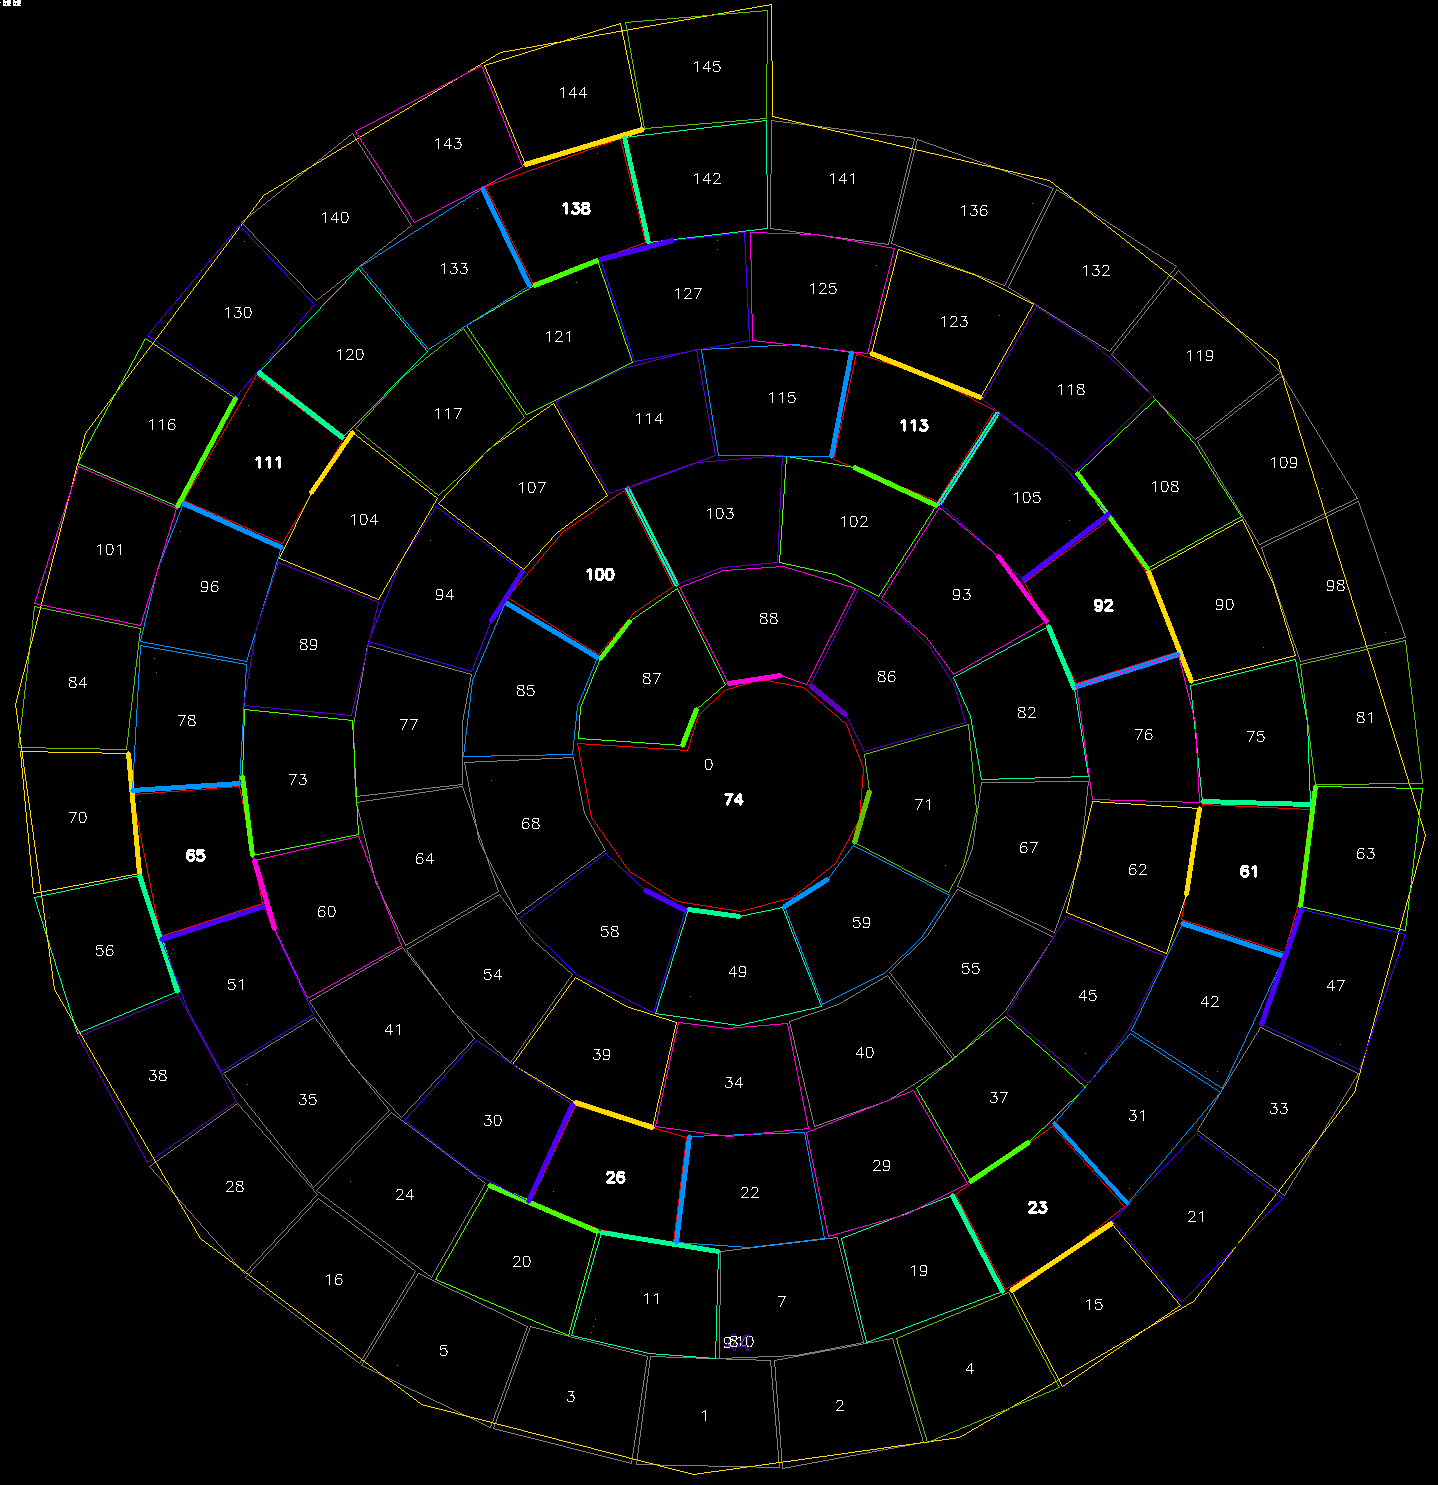

In [5]:
g = get_grid('spiral.png')
height, width = g.grid.shape
image = np.zeros((height, width, 3), np.uint8)
im2, contours, hierarchy = cv2.findContours(g.grid.copy(), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
target_contours = {23, 26, 61, 65, 74, 92, 100, 111, 113, 138}
n_neighbors = 9  # Assumes 3x3 grid of 2d squares.

filtered = []
for i, c in enumerate(contours):
  peri = cv2.arcLength(c, True)
  approx = cv2.approxPolyDP(c, 0.01 * peri, True)
  contour_instance = Contour(str(i), c, approx)
  contour_instance.draw_on(image, color=(128, 128, 128), bold=i in target_contours)
  filtered.append(contour_instance)

for target_contour in target_contours:
  neighbors = NearestNeighbors(n_neighbors)  
  neighbors.fit([(c.cX, c.cY) for c in filtered])

  target = filtered[target_contour]
  d, n = neighbors.kneighbors([(target.cX, target.cY)], n_neighbors=n_neighbors)
  colors = coloring.colors(n_neighbors)
  print('Checking neighbors for', target.name)
  for dist, pos, color in zip(*d, *n, colors):
    color = color.tolist()
    c = filtered[pos]
    c.draw_on(image, color=color)
    if dist:
      segments = wall_segments(target, c, dist / 4)
      for s1, s2, dist in segments:
        #print('distance: %.2f' % dist)
        cv2.line(image, tuple(s2[0]), tuple(s2[1]), color, 3)
      #if segments:
      #  print('-' * 40)
  #print('\n')

print(str(dist_technique))
print(str(segment_intersection))
show(image)
# next, previous, child, parent
# print(hierarchy)

arrow.png 368


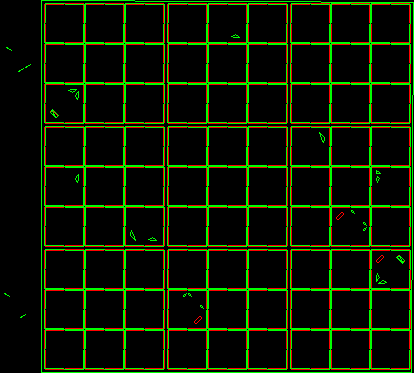

askew.png 98


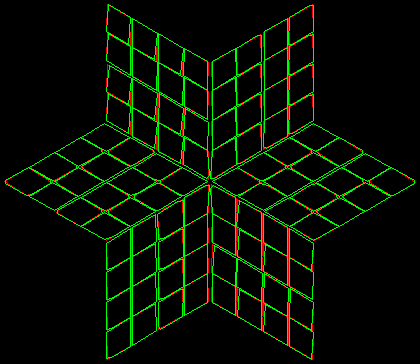

cages.png 188


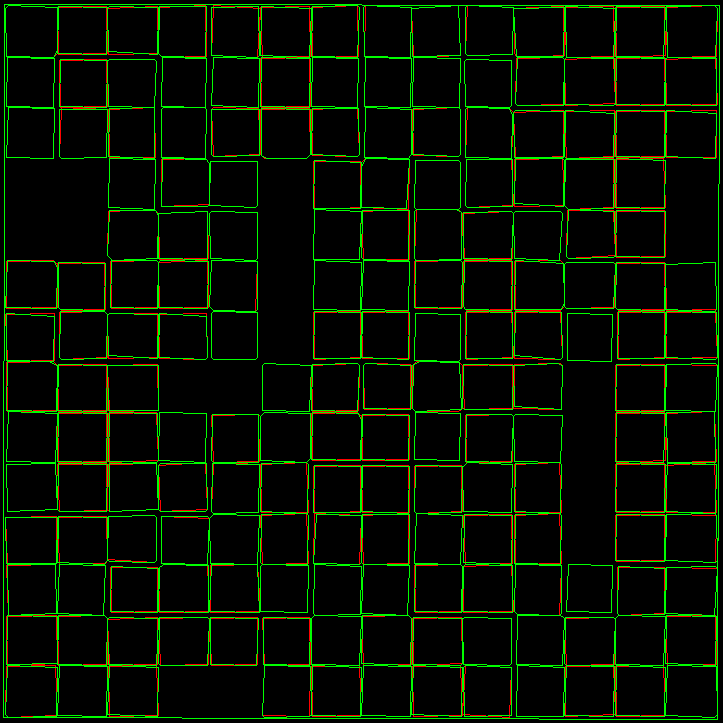

castlewall.png 131


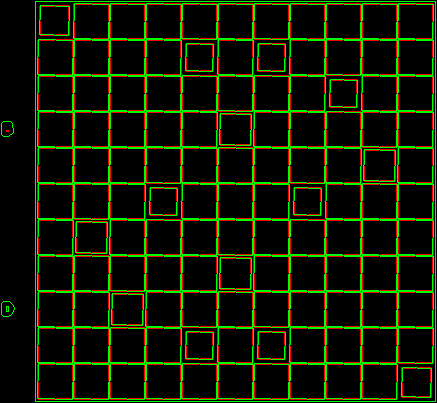

crossword.png 190


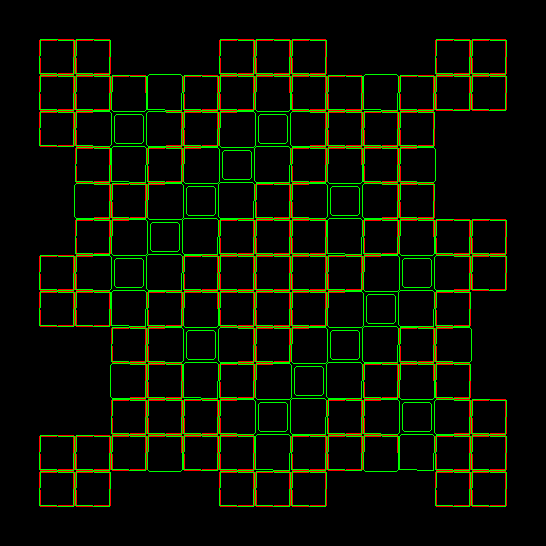

fillomino.png 542


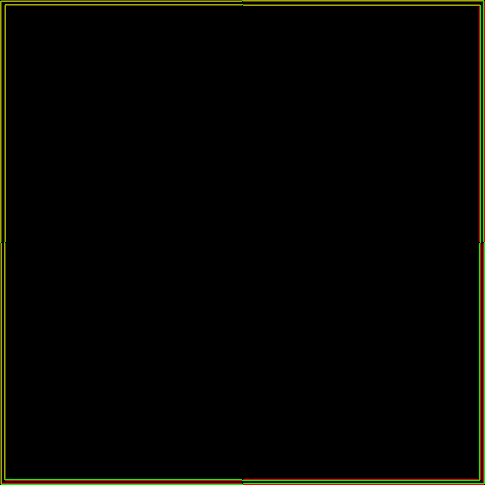

kakuro.png 75


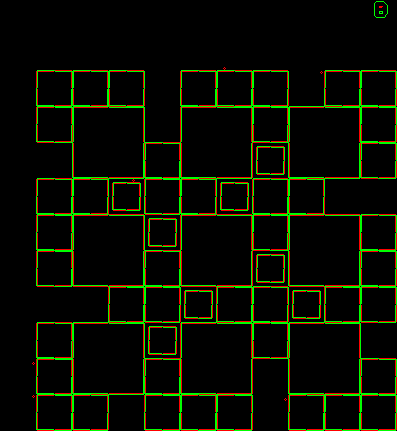

kenken.png 41


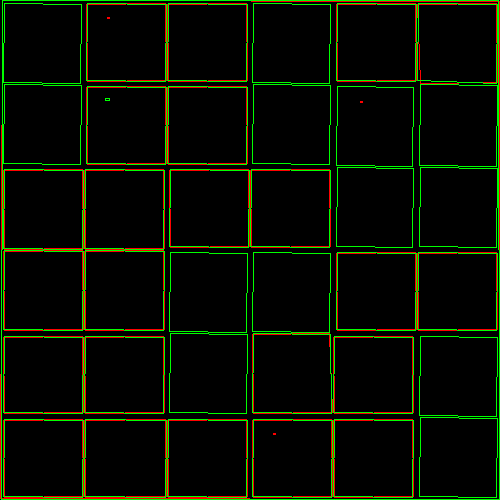

masyu.png 1458


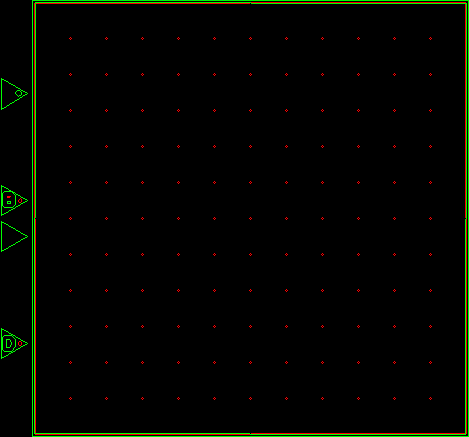

multi.png 193


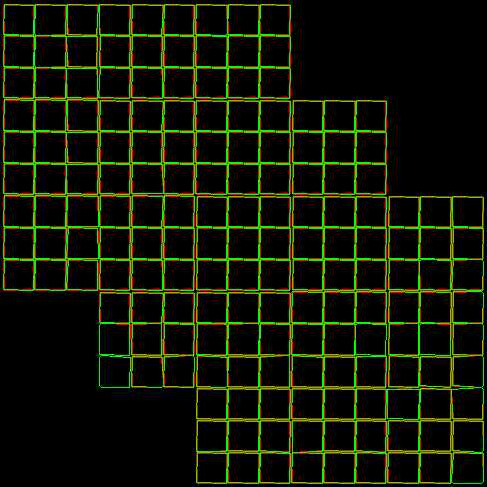

nonogram.png 542


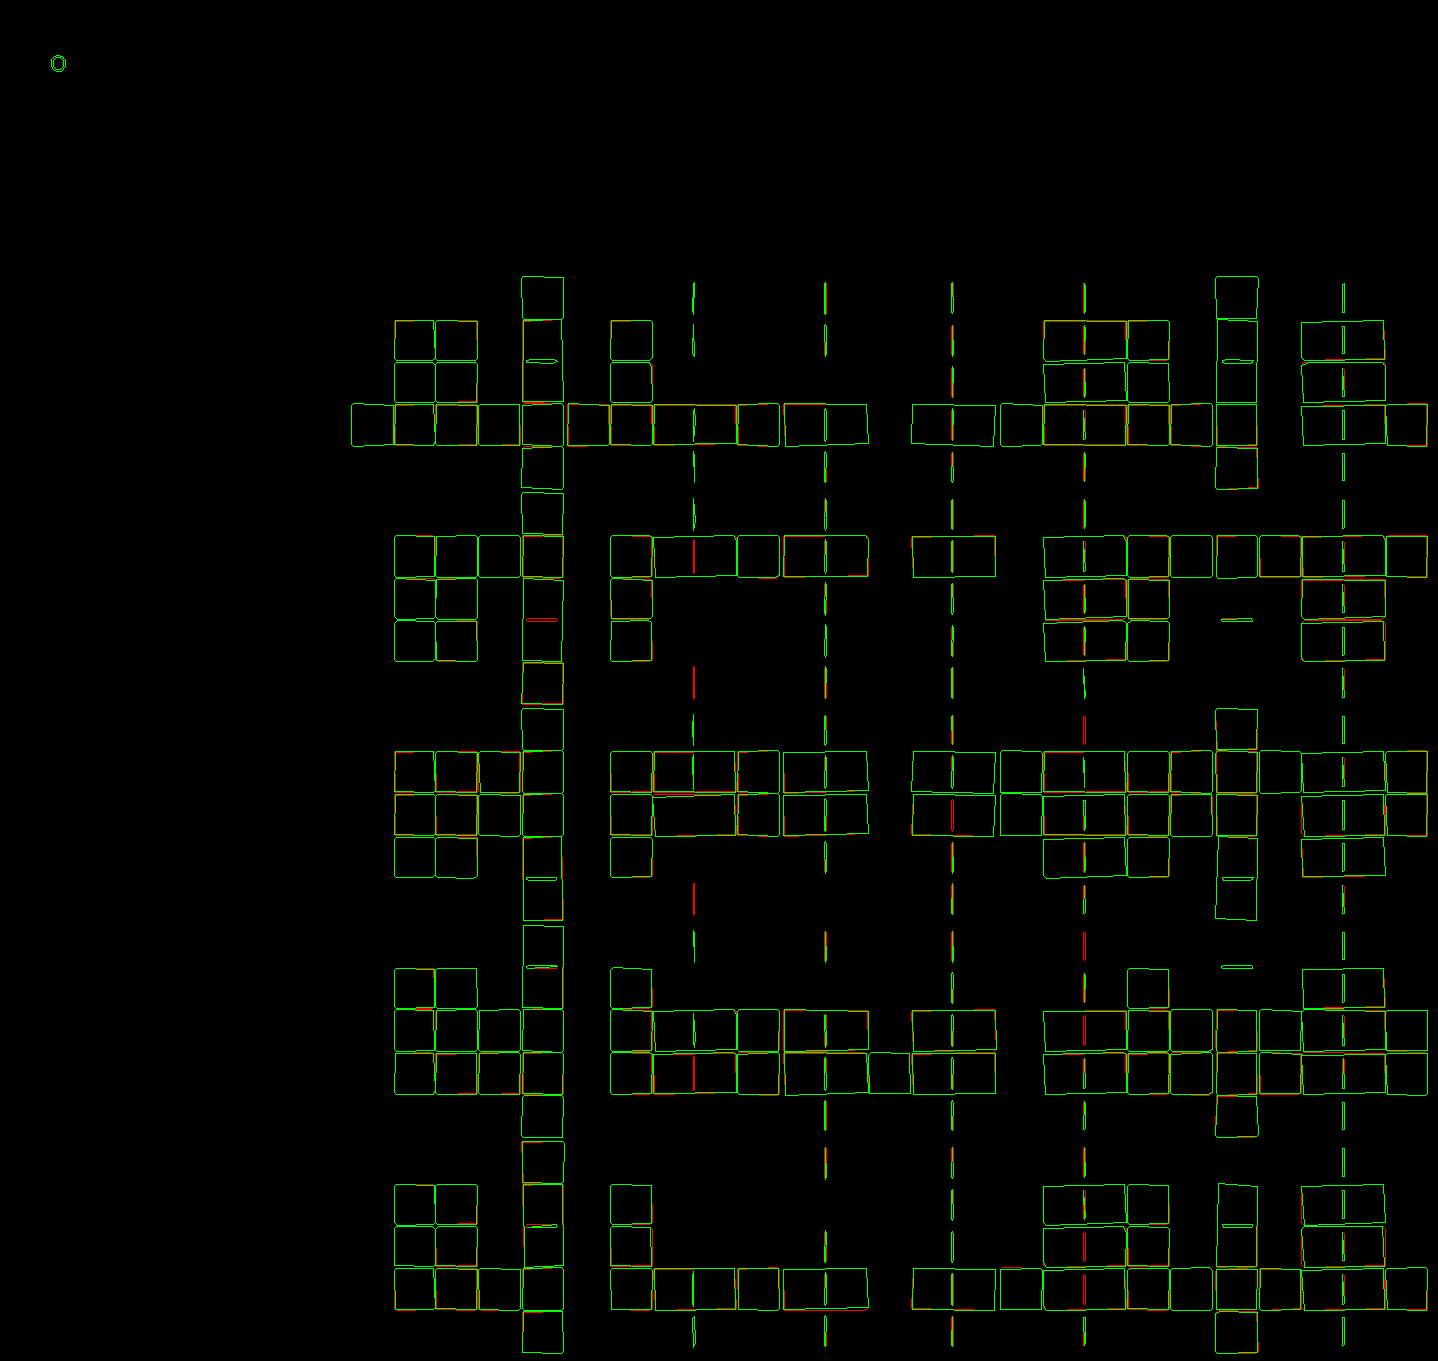

nurimaze.png 919


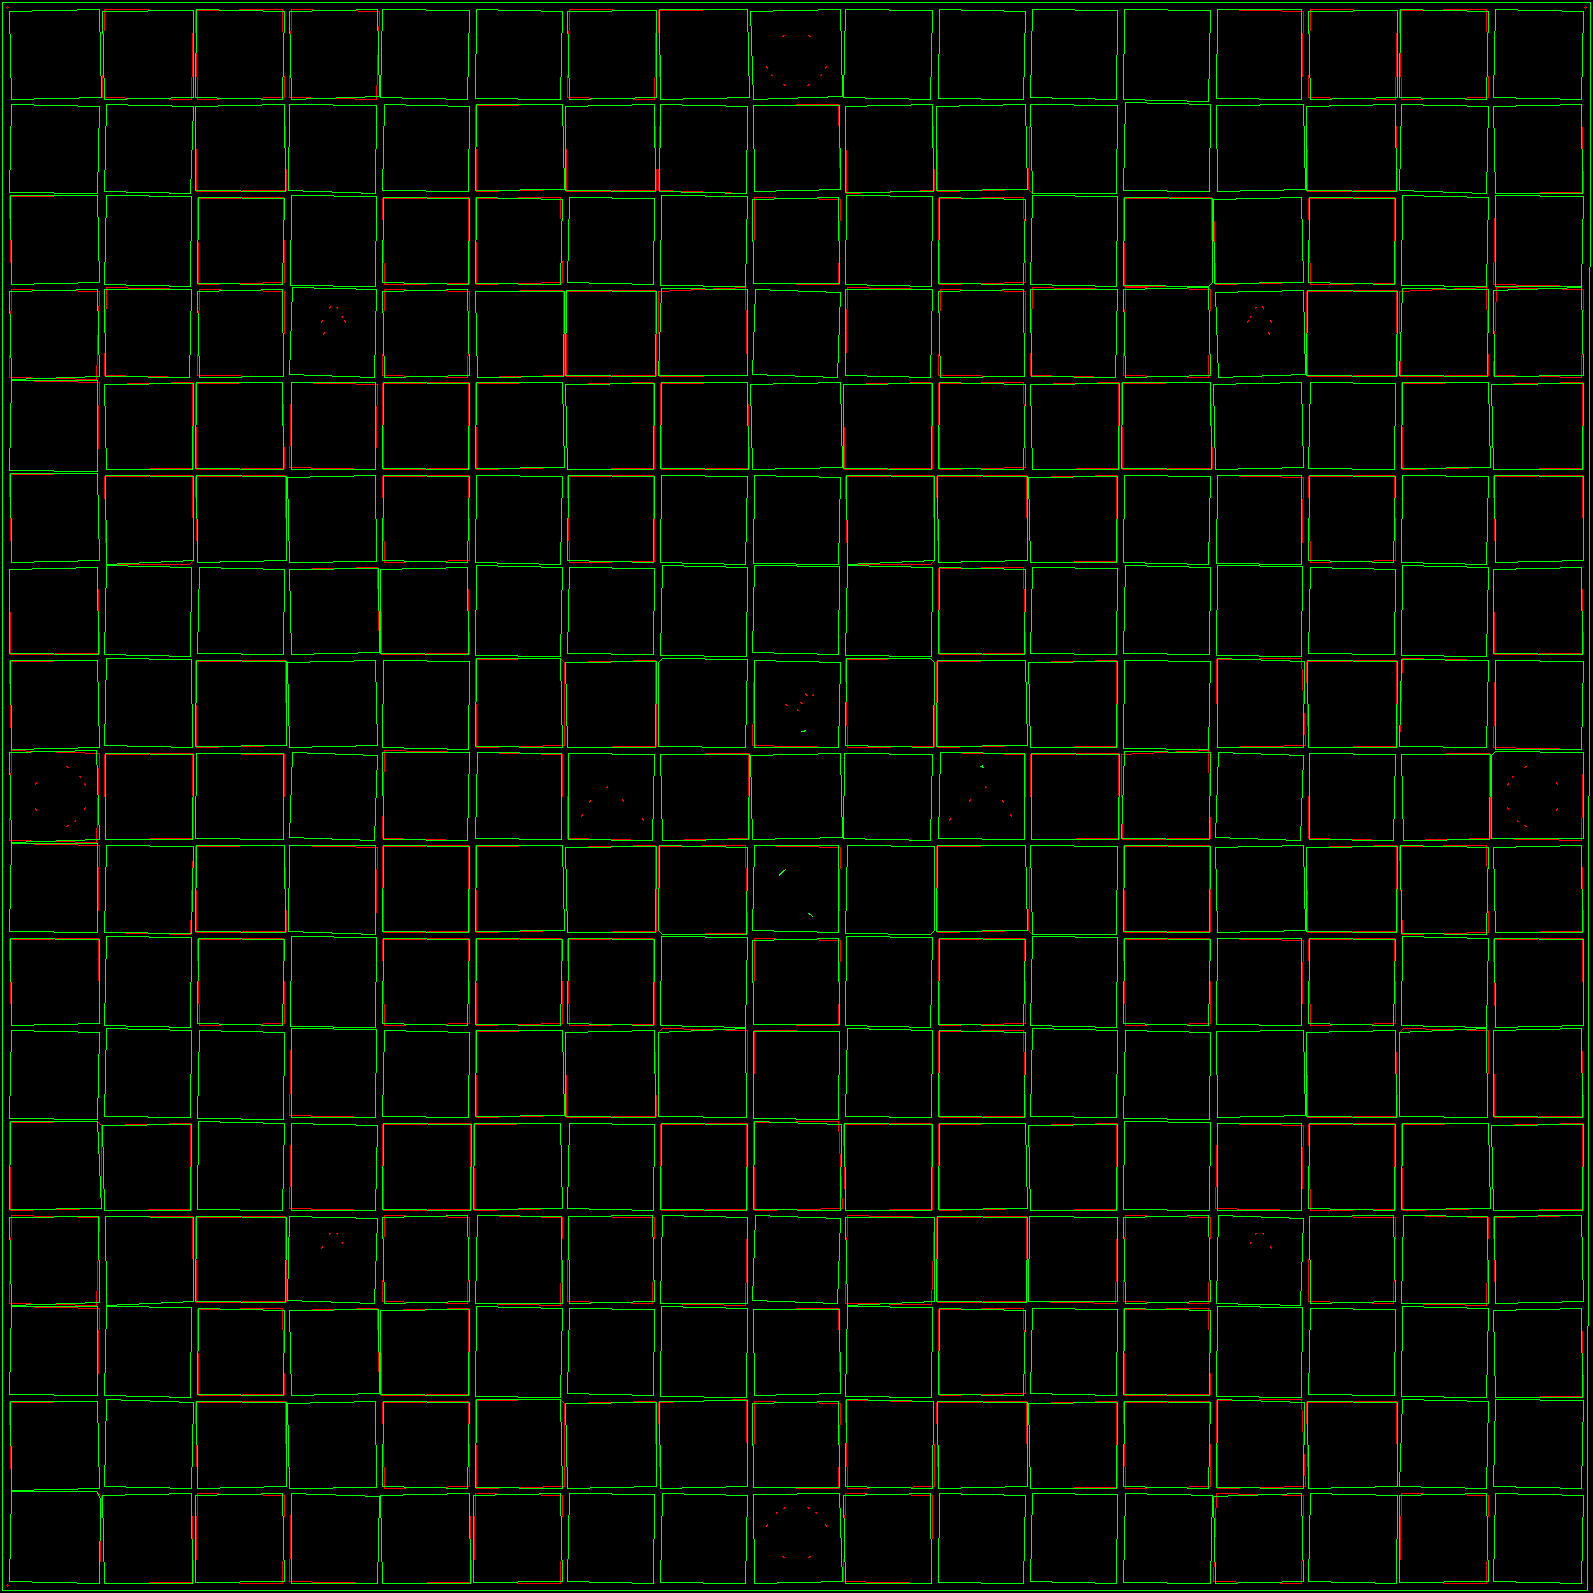

pentopia.png 340


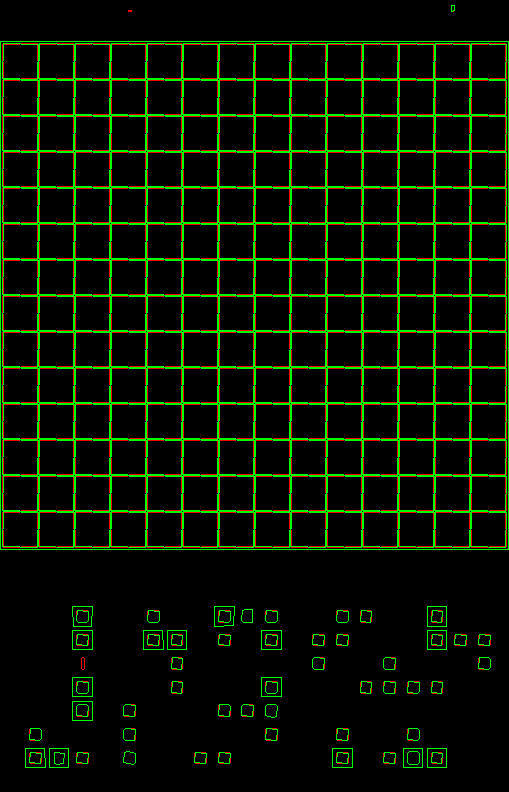

skyscraper.png 40


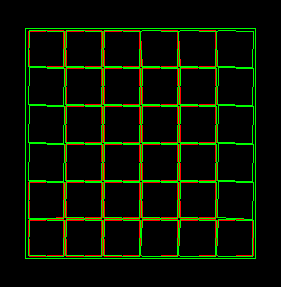

slitherlink.png 144


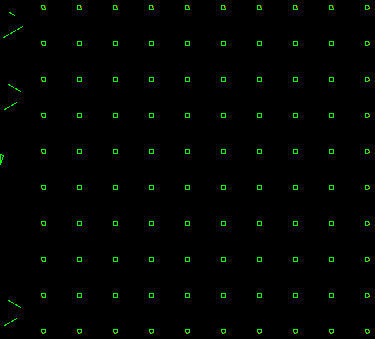

spiral.png 146


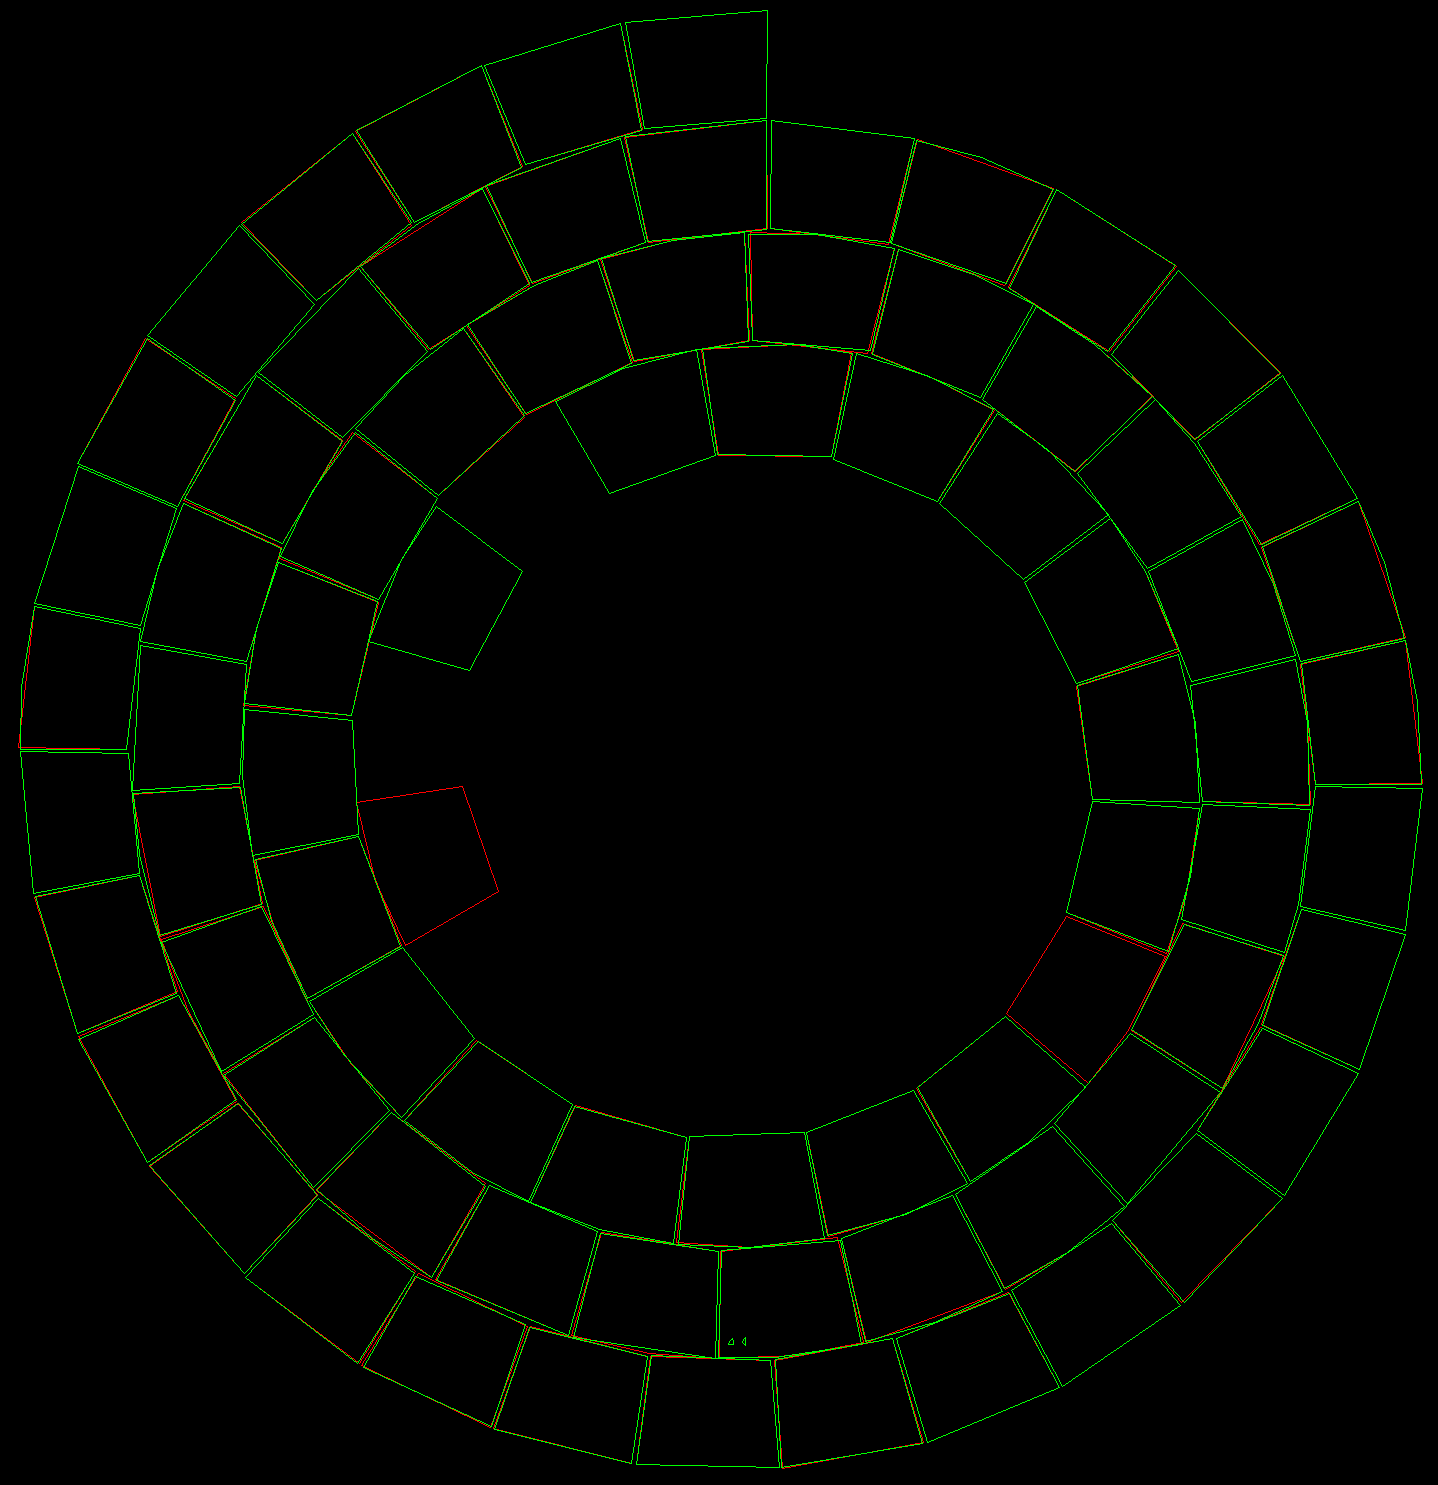

strimko.png 24


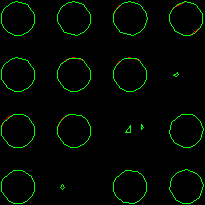

thermo.png 171


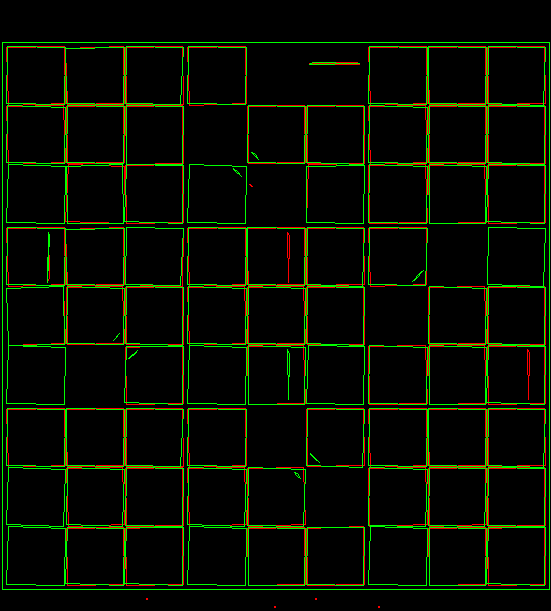

wordsearch.png 252


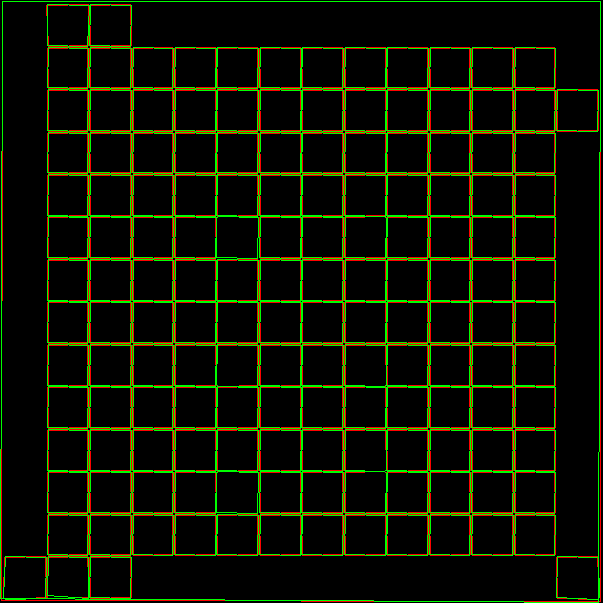

wordsearch_with_bank.png 103


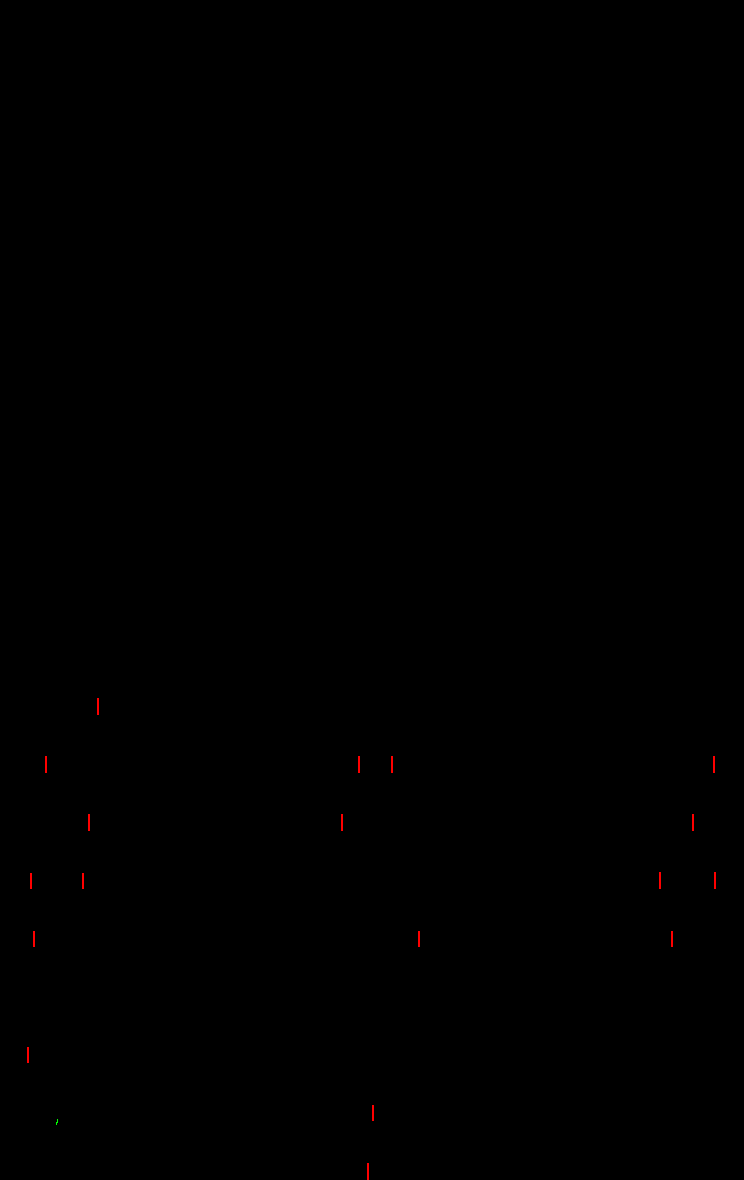

In [6]:
for name, g in grids():
  height, width = g.grid.shape
  image = np.zeros((height, width, 3), np.uint8)
  im2, contours, hierarchy = cv2.findContours(g.grid, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
  for c in contours:
    peri = cv2.arcLength(c, True)
    approx = cv2.approxPolyDP(c, 0.01 * peri, True)
    if cv2.isContourConvex(approx):
      cv2.drawContours(image, [approx], -1, (255, 0, 0), 1)
  im2, contours, hierarchy = cv2.findContours(g.grid, cv2.RETR_TREE, cv2.CHAIN_APPROX_TC89_L1)
  for c in contours:
    peri = cv2.arcLength(c, True)
    approx = cv2.approxPolyDP(c, 0.01 * peri, True)
    if cv2.isContourConvex(approx):
      cv2.drawContours(image, [approx], -1, (0, 255, 0), 1)
  print(name, len(contours))
  show(image)

In [7]:
(
  TL, T, TR,
  L, M, R,
  BL, B, BR,
) = np.array([
  (0, 0), (1, 0), (2, 0),
  (0, 1), (1, 1), (2, 1),
  (0, 2), (1, 2), (2, 2),
]) * 100
